In [65]:
import pandas as pd
import os
import numpy as np

data_path = os.path.join("eDo", "data", "processed.csv")
df = pd.read_csv(data_path, parse_dates=['DateTime'], index_col='DateTime')

df = df.dropna()
print(df.head())


                         Open      High       Low     Close      Volume  \
DateTime                                                                  
2022-01-25 13:00:00  36519.12  36579.99  36259.10  36498.00  2008.17575   
2022-01-25 14:00:00  36497.39  37149.42  36252.00  36299.99  5493.26524   
2022-01-25 15:00:00  36299.99  36780.00  35967.33  36530.00  3943.20294   
2022-01-25 16:00:00  36530.00  37086.64  36492.48  36837.70  2613.07831   
2022-01-25 17:00:00  36837.70  37481.75  36800.00  37273.33  3299.07838   

                      log_ret  fracdiff  
DateTime                                 
2022-01-25 13:00:00 -0.000579  0.103441  
2022-01-25 14:00:00 -0.005440  0.097746  
2022-01-25 15:00:00  0.006316  0.107048  
2022-01-25 16:00:00  0.008388  0.112089  
2022-01-25 17:00:00  0.011756  0.118196  


In [38]:
train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size].copy()
test_df  = df.iloc[train_size:].copy()

print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")


Train size: 20136, Test size: 5035


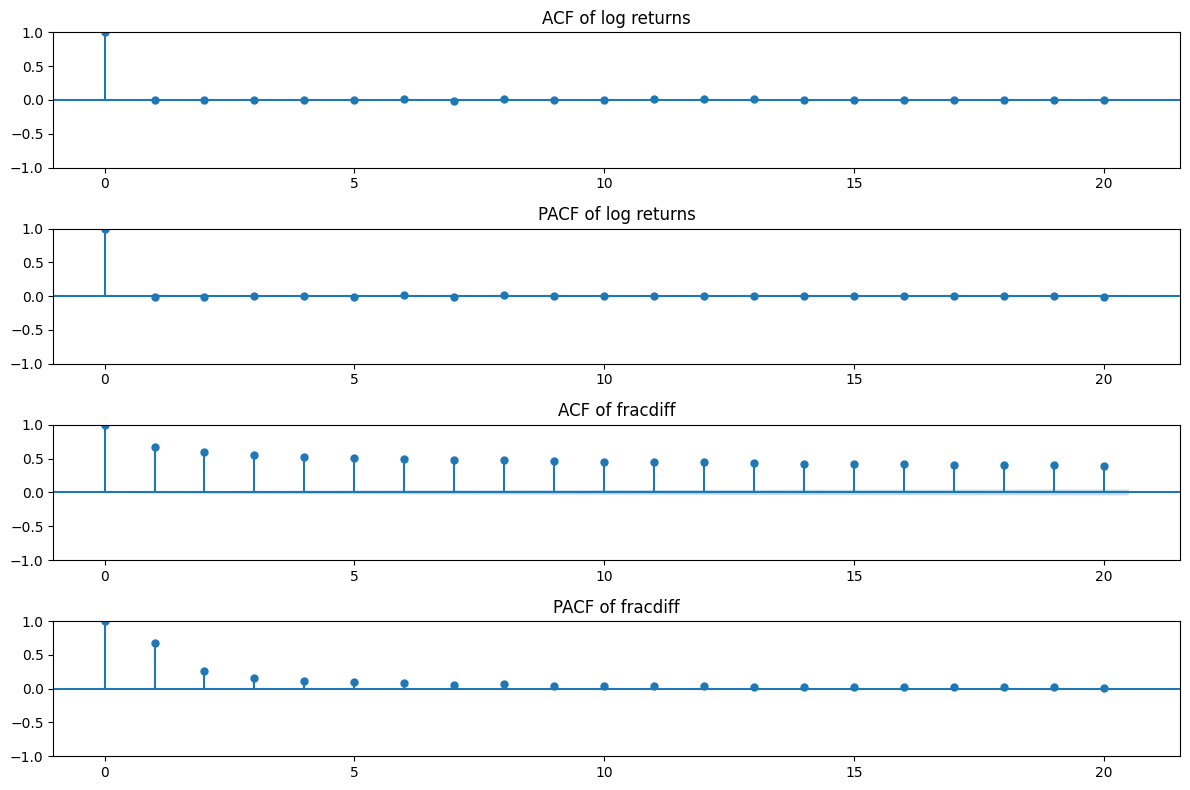

In [39]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 1, figsize=(12, 8))

plot_acf(train_df['log_ret'], ax=axes[0], lags=20, title="ACF of log returns")
plot_pacf(train_df['log_ret'], ax=axes[1], lags=20, title="PACF of log returns")
plot_acf(train_df['fracdiff'], ax=axes[2], lags=20, title="ACF of fracdiff")
plot_pacf(train_df['fracdiff'], ax=axes[3], lags=20, title="PACF of fracdiff")
plt.tight_layout()
plt.show()


In [40]:
from pmdarima import auto_arima

stepwise_model_logret = auto_arima(
    train_df['log_ret'],
    start_p=1, start_q=1,
    max_p=5, max_q=5,
    d=0,           # because we assume log_ret is already differenced
    seasonal=False,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print(stepwise_model_logret.summary())


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-150430.941, Time=1.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-150433.847, Time=0.59 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-150432.716, Time=0.55 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-150432.730, Time=0.96 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-150432.286, Time=2.29 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 5.629 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                20136
Model:                        SARIMAX   Log Likelihood               75217.924
Date:                Mon, 30 Dec 2024   AIC                        -150433.847
Time:                        17:23:06   BIC                        -150425.937
Sample:                    01-25-2022   HQIC                       -150431.260
                         - 05-13-2024                        

In [41]:
stepwise_model_fracdiff = auto_arima(
    train_df['fracdiff'],
    start_p=1, start_q=1,
    max_p=5, max_q=5,
    d=0,           # because its already fractionally differenced
    seasonal=False,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print(stepwise_model_fracdiff.summary())


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-149274.275, Time=2.96 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-34856.083, Time=0.50 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.81 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-60337.855, Time=0.93 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-150071.922, Time=2.83 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.69 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-147839.873, Time=1.61 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-149344.912, Time=2.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-149564.857, Time=1.52 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=1.44 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-149628.912, Time=2.17 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-149337.226, Time=18.69 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 36.278 seconds
                               SARIMAX Results                              

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

p, d, q = (2, 0, 1)
fracdiff_model = ARIMA(train_df['fracdiff'], order=(p, d, q)).fit()
print(fracdiff_model.summary())

p, d, q = (0, 0, 0)
log_ret_model = ARIMA(train_df['log_ret'], order=(p, d, q)).fit()
print(log_ret_model.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:               fracdiff   No. Observations:                20136
Model:                 ARIMA(2, 0, 1)   Log Likelihood               75123.741
Date:                Mon, 30 Dec 2024   AIC                        -150237.481
Time:                        17:23:56   BIC                        -150197.930
Sample:                    01-25-2022   HQIC                       -150224.545
                         - 05-13-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1013      0.001    197.961      0.000       0.100       0.102
ar.L1          1.2652      0.005    235.725      0.000       1.255       1.276
ar.L2         -0.2772      0.005    -55.880      0.0

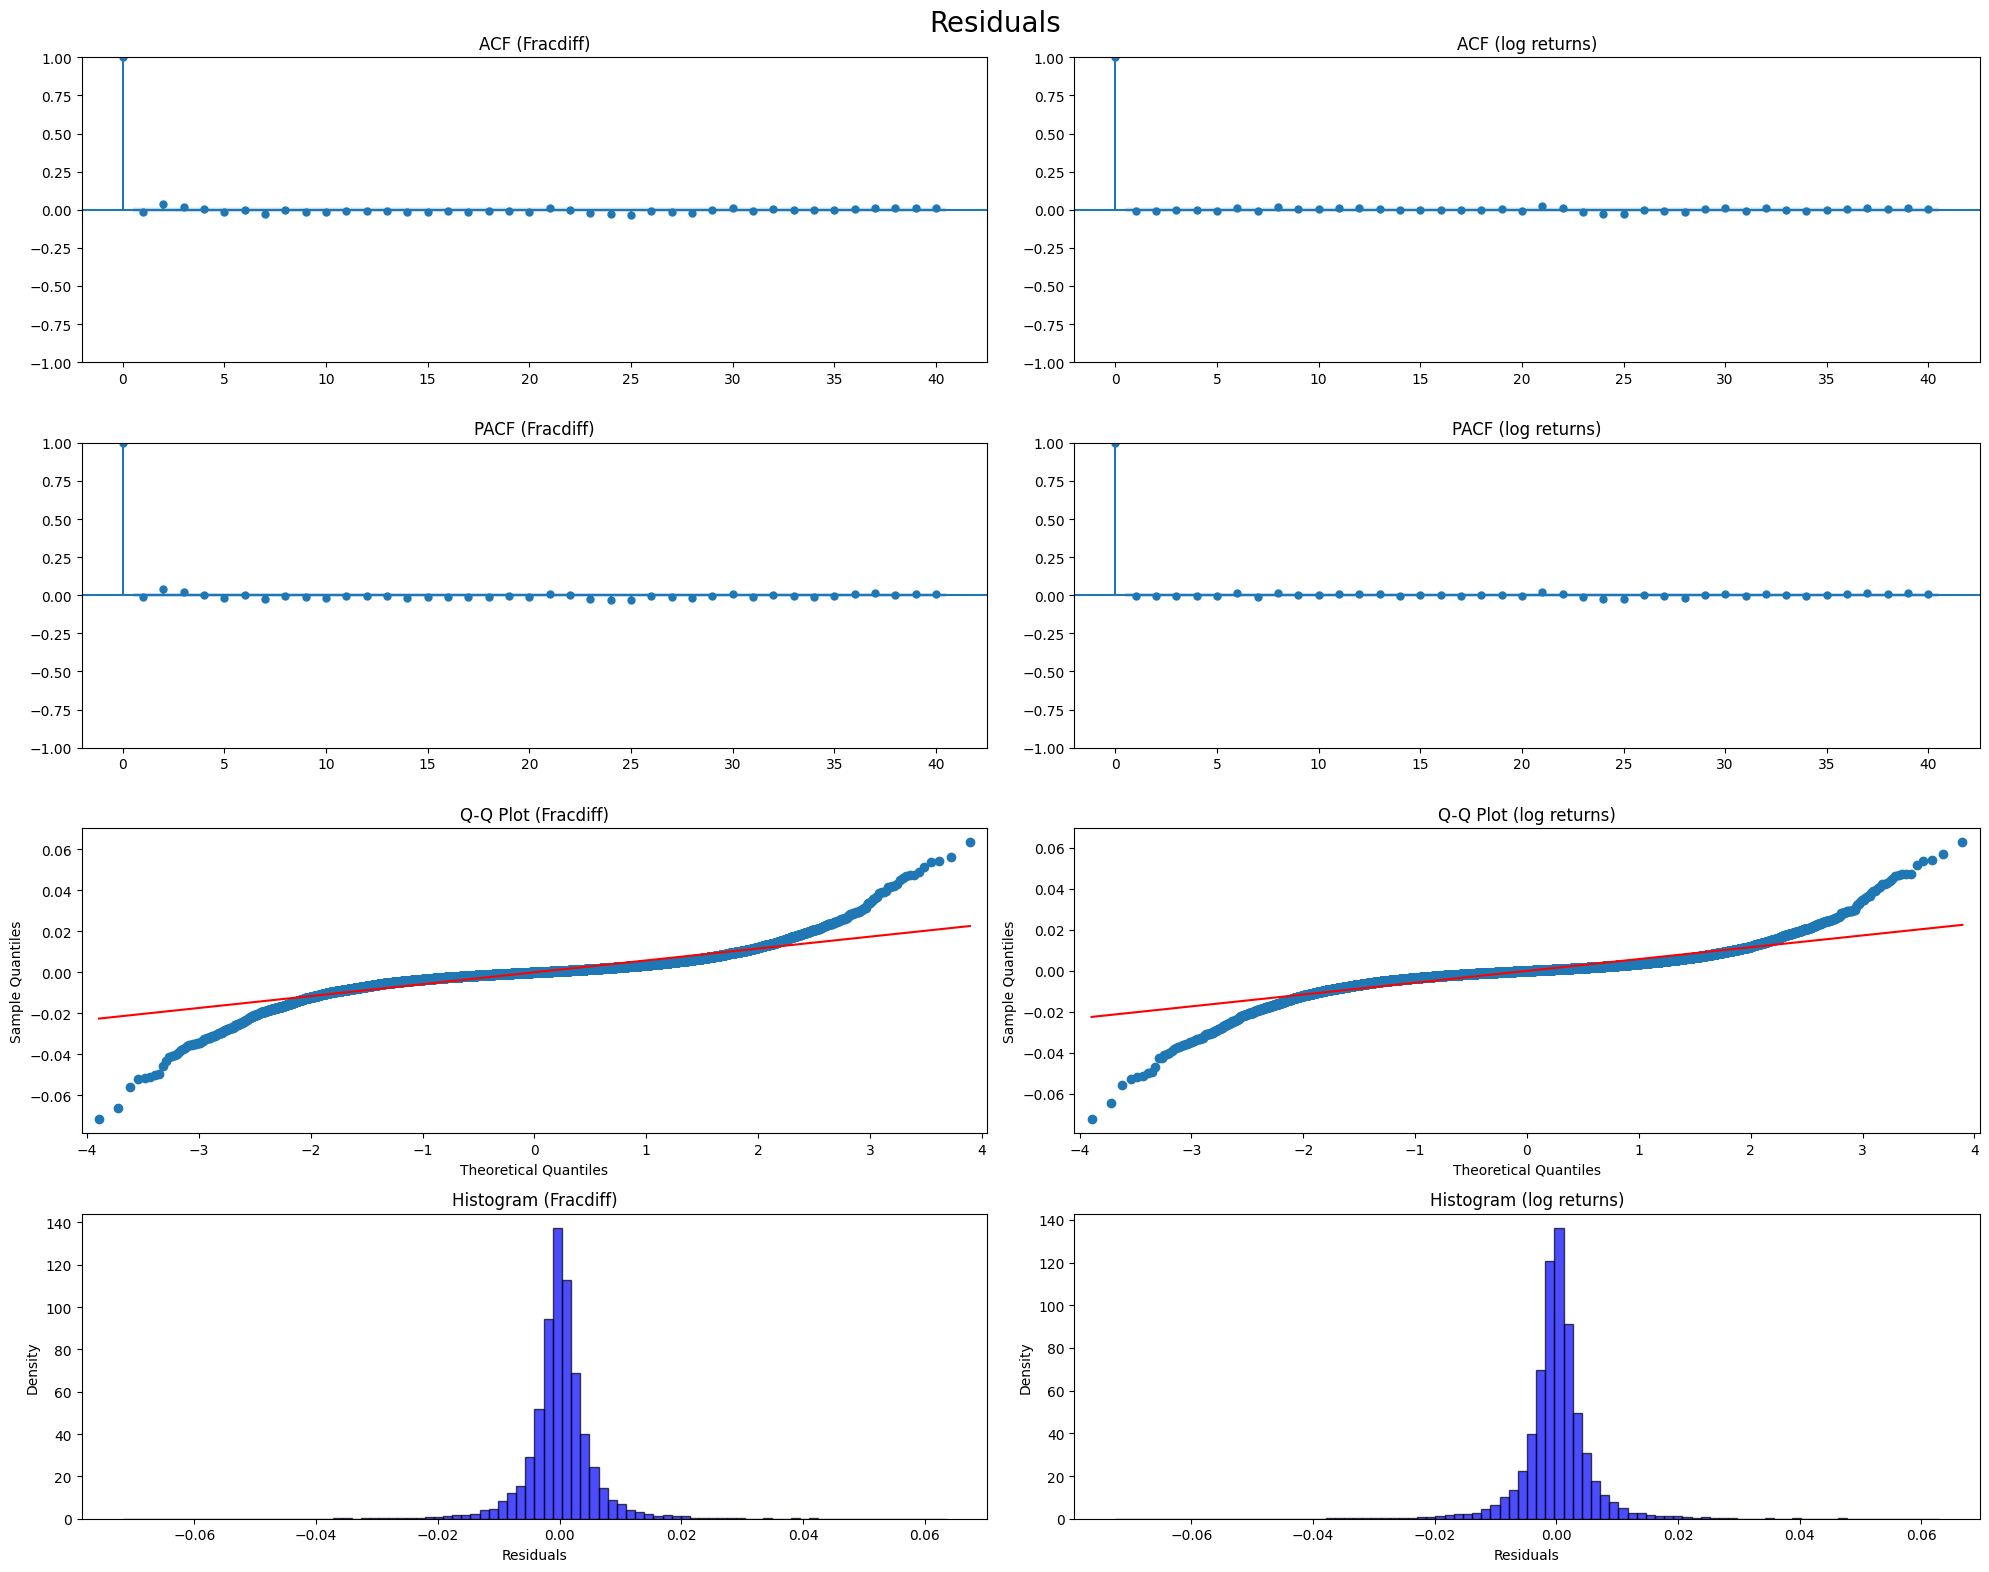

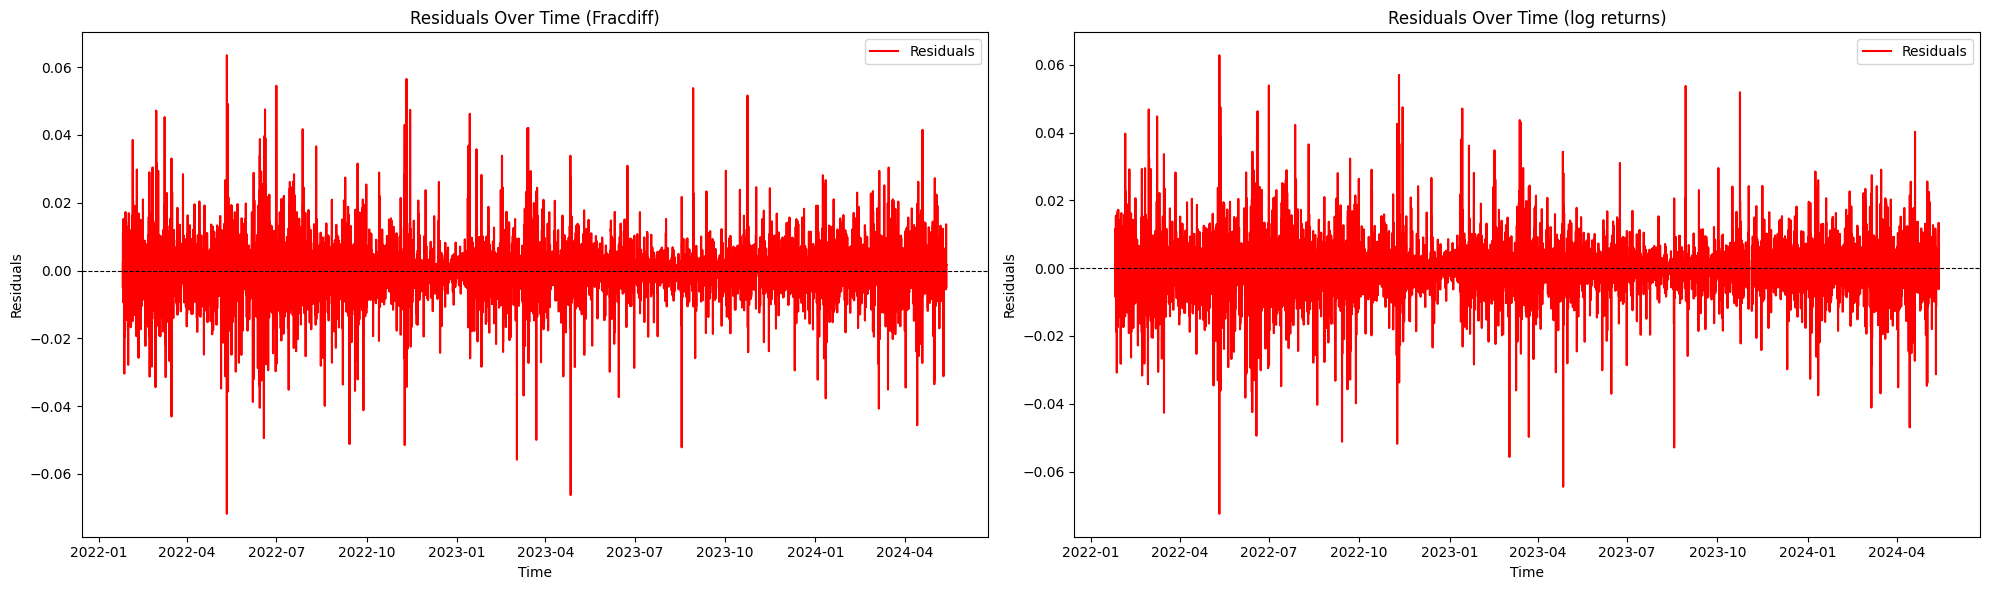

In [56]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

residuals_fracdiff = fracdiff_model.resid
residuals_log_ret = log_ret_model.resid.dropna()

fig, axes = plt.subplots(4, 2, figsize=(20, 16))

# ACF and PACF for Fracdiff residuals
plot_acf(residuals_fracdiff, ax=axes[0, 0], lags=40, title="ACF (Fracdiff)")
plot_pacf(residuals_fracdiff, ax=axes[1, 0], lags=40, title="PACF (Fracdiff)")

# ACF and PACF for log returns residuals
plot_acf(residuals_log_ret, ax=axes[0, 1], lags=40, title="ACF (log returns)")
plot_pacf(residuals_log_ret, ax=axes[1, 1], lags=40, title="PACF (log returns)")

# Q-Q Plots
sm.qqplot(residuals_fracdiff, line='s', ax=axes[2, 0])
axes[2, 0].set_title("Q-Q Plot (Fracdiff)")
sm.qqplot(residuals_log_ret, line='s', ax=axes[2, 1])
axes[2, 1].set_title("Q-Q Plot (log returns)")

# Residual Histograms
axes[3, 0].hist(residuals_fracdiff, bins=90, density=True, alpha=0.7, color='blue', edgecolor='black')
axes[3, 0].set_title("Histogram (Fracdiff)")
axes[3, 0].set_xlabel("Residuals")
axes[3, 0].set_ylabel("Density")

axes[3, 1].hist(residuals_log_ret, bins=90, density=True, alpha=0.7, color='blue', edgecolor='black')
axes[3, 1].set_title("Histogram (log returns)")
axes[3, 1].set_xlabel("Residuals")
axes[3, 1].set_ylabel("Density")

plt.tight_layout()
plt.show()

# Residual Time Series Plots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Residuals over time for Fracdiff
axes[0].plot(residuals_fracdiff, label='Residuals', color='red')
axes[0].axhline(y=0, color='black', linestyle='--', linewidth=0.8)
axes[0].set_title("Residuals Over Time (Fracdiff)")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Residuals")
axes[0].legend()

# Residuals over time for log returns
axes[1].plot(residuals_log_ret, label='Residuals', color='red')
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=0.8)
axes[1].set_title("Residuals Over Time (log returns)")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Residuals")
axes[1].legend()

plt.tight_layout()
plt.show()


# GARCH

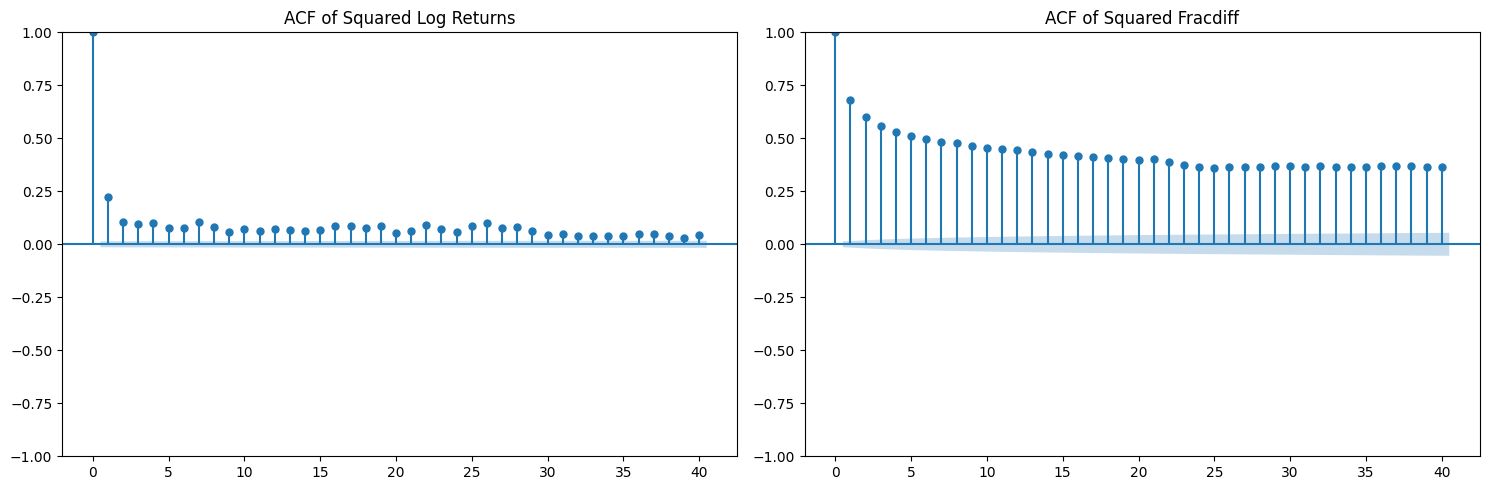

In [64]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

plot_acf(train_df['log_ret']**2, lags=40, 
         title="ACF of Squared Log Returns", ax=axes[0])

plot_acf(train_df['fracdiff']**2, lags=40, 
         title="ACF of Squared Fracdiff", ax=axes[1])

plt.tight_layout()
plt.show()


This means the volatility has tendency to cluster and is present for some time after an event.

In [66]:
from statsmodels.stats.diagnostic import het_arch

arch_test = het_arch(train_df['fracdiff'])
# arch_test returns (LM stat, LM p-value, F-stat, F p-value)
print("ARCH test:", arch_test)

arch_test = het_arch(train_df['log_ret'])
print("ARCH test:", arch_test)


ARCH test: (10665.133068987026, 0.0, 2267.5422162364616, 0.0)
ARCH test: (1409.0169132192302, 1.121160371648046e-296, 151.42598076835466, 9.647509618411445e-308)


# ARIMA + GARCH

In [60]:
import itertools
from arch import arch_model

best_aic = np.inf
best_order = None
best_model = None

p_range = range(1, 6)
q_range = range(1, 6)

arima_resid  = fracdiff_model.resid.dropna()*100

for p, q in itertools.product(p_range, q_range):

        model = arch_model(arima_resid, mean='Zero', vol='GARCH', p=p, q=q)
        res = model.fit(disp='off')
        if res.aic < best_aic:
            best_aic = res.aic
            best_order = (p, q)
            best_model = res

print(f"Best GARCH model order: p={best_order[0]}, q={best_order[1]} with AIC={best_aic}")
print(best_model.summary())


Best GARCH model order: p=1, q=5 with AIC=29153.208103557394
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -14569.6
Distribution:                  Normal   AIC:                           29153.2
Method:            Maximum Likelihood   BIC:                           29208.6
                                        No. Observations:                20136
Date:                Mon, Dec 30 2024   Df Residuals:                    20136
Time:                        18:10:34   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
--------------------------------------------------------------------------

In [62]:
garch_forecast = best_model.forecast(horizon=5)  # forecast next 5 steps
var_forecast = garch_forecast.variance.iloc[-1]
print("5-step ahead variance:", var_forecast.values)
print("5-step ahead volatility:", np.sqrt(var_forecast.values))


5-step ahead variance: [0.34085985 0.38381635 0.38391173 0.37378179 0.36936245]
5-step ahead volatility: [0.58383204 0.61952914 0.61960611 0.61137696 0.60775196]


In [68]:
n_test = len(test_df)

arima_forecast = fracdiff_model.get_forecast(steps=n_test)

arima_mean_pred = arima_forecast.predicted_mean

garch_forecast = best_model.forecast(horizon=n_test, reindex=False)


garch_var_forecast = garch_forecast.variance.values[-1, :]  
garch_vol_forecast = np.sqrt(garch_var_forecast)


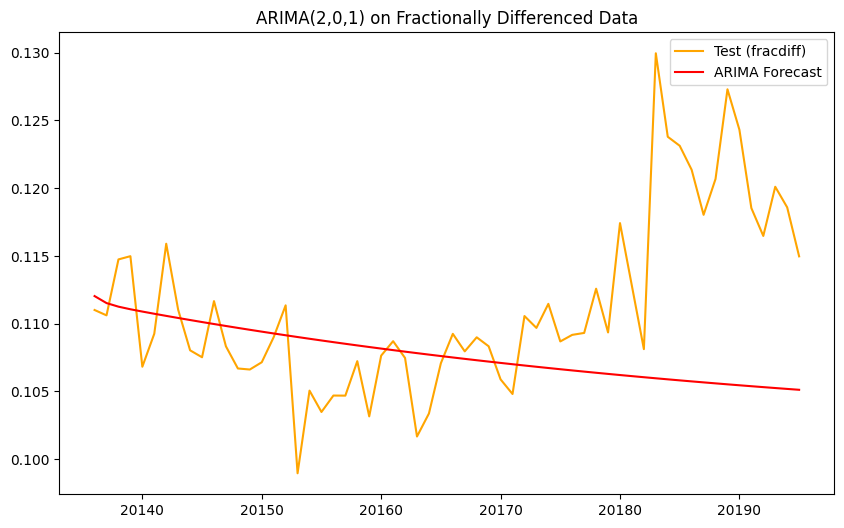

In [83]:
fitted_values = fracdiff_model.fittedvalues

n_test =20
arima_mean_pred = fracdiff_model.get_forecast(steps=n_test).predicted_mean

plt.figure(figsize=(10,6))
# plt.plot(train_df['fracdiff'].values, label='Train (fracdiff)', color='blue')
# plt.plot(fitted_values.values, label='ARIMA In-Sample Fit', color='green')

plt.plot(np.arange(train_size, train_size+n_test), test_df['fracdiff'].values[0:n_test], label='Test (fracdiff)', color='orange')
plt.plot(np.arange(train_size, train_size+n_test), arima_mean_pred,
         label='ARIMA Forecast', color='red')
plt.legend()
plt.title("ARIMA(2,0,1) on Fractionally Differenced Data")
plt.show()


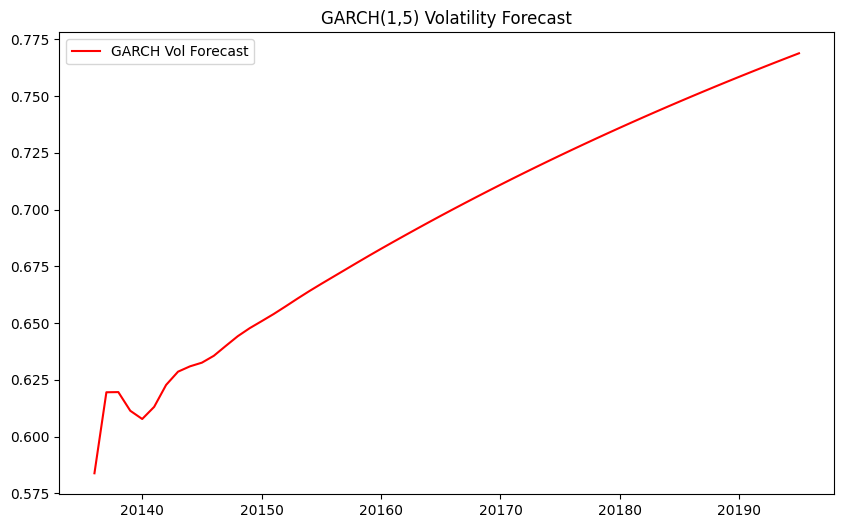

In [85]:
# In-sample conditional volatility
in_sample_vol = best_model.conditional_volatility

# Out-of-sample forecast
garch_vol_forecast = best_model.forecast(horizon=n_test, reindex=False)
out_of_sample_vol = garch_vol_forecast.variance.values[-1,:]**0.5  # sqrt of variance

plt.figure(figsize=(10,6))
#plt.plot(in_sample_vol, label="In-Sample Vol", color='blue')
# The last in-sample index is len(train_df)-1 if you used the same data
plt.plot(range(len(train_df), len(train_df)+n_test), out_of_sample_vol, 
         label="GARCH Vol Forecast", color='red')
plt.title("GARCH(1,5) Volatility Forecast")
plt.legend()
plt.show()
